In [27]:
# data science & classics
import pandas as pd
import numpy as np
import networkx as nx
import os, sys
import scipy,torch
from scipy import sparse

from sklearn.cluster import SpectralBiclustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy

import sklearn
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
def find_optime_threshold(G,operator,candidate_thres,min_gene_num):
    operator = operator # > or <

    all_genes_in_modules = []
    def get_overlap_old(modules):
        total_overlap = 0
        for m in modules:
            total_overlap += len([n for n in m if n in all_genes_in_modules])
        return total_overlap


    def get_number_of_modules(threshold):
        to_remove = []
        for u, v, weight in G.edges(data='weight'):
            if operator == '<':
                if weight < threshold:
                    to_remove.append((u, v))
            elif operator == '>':
                if weight > threshold:
                    to_remove.append((u, v))
        G_copy = G.copy()
        G_copy.remove_edges_from(to_remove)
        modules = [c for c in sorted(nx.strongly_connected_components(G_copy), key=len, reverse=True) if len(c) >= min_gene_num]
        module_sizes = [len(m) for m in modules]
        return len(module_sizes), get_overlap_old(modules)

    compute_optimal_cutoff=True

    if compute_optimal_cutoff:
    #     thresholds = list(range(1,60))  # np.arange(.1, .2, )
        thresholds = candidate_thres
        number_of_modules = []
        n = 0
        for thr in thresholds:
            n += 1
            # print(thresholds.index(thr))
            if n%4 == 0:
                print(thr)
            number_of_modules.append(get_number_of_modules(thr))
        overlap = [i[1] for i in number_of_modules]
        number_of_modules = [i[0] for i in number_of_modules]
    #
        fig = plt.figure(figsize=(14, 8))
        # plt.subplot(2, 1, 1)
        plt.bar(x=list(range(len(number_of_modules))), height=number_of_modules)
        _ = plt.xticks(ticks=list(range(len(number_of_modules))), labels=['{0:.3f}'.format(i) for i in thresholds],
                       fontsize=15)
        plt.xlabel('Thresholds for Edge Weight', fontsize=20)
        plt.ylabel(f'Number of Modules of Size $\geq$ {min_gene_num}', fontsize=20)
        print(number_of_modules)
        plt.gca().tick_params(axis='y', which='major', labelsize=20)
        plt.gca().tick_params(axis='x', rotation=90)
        plt.tight_layout()
    #     fig.savefig(os.path.join("./final_result", 'module_sizes_posonly_finegrained_diffe_larger2_driver.svg'))
        plt.show()
        

In [3]:
def find_SCCs(G,thres, operator,min_gene_num):
    min_edge_weight = thres
    G_copy = G.copy()
    edge_weights = nx.get_edge_attributes(G,'weight')
    if operator=='<':
        G_copy.remove_edges_from((e for e, w in edge_weights.items() if w < min_edge_weight))
    elif operator=='>':
        G_copy.remove_edges_from((e for e, w in edge_weights.items() if w > min_edge_weight))
#     print([len(c) for c in sorted(nx.strongly_connected_components(G_copy), key=len, reverse=True) if len(c) >= min_gene_num])
#     print(len(max(nx.strongly_connected_components(G_copy), key=len)))
    nodes_component = list(max(nx.strongly_connected_components(G_copy), key=len))
    x = pd.DataFrame(nodes_component, columns=['Name'])
    all_components = [list(c) for c in sorted(nx.strongly_connected_components(G_copy), key=len, reverse=True) if len(c) > 1]
    all_components_larger = [list(c) for c in sorted(nx.strongly_connected_components(G_copy), key=len, reverse=True) if len(c) >= min_gene_num]
#     g = [j for i in all_components_larger for j in i]
#     print(len(all_components_larger))
#     print(np.mean([len(i) for i in all_components_larger]))
    return all_components

In [4]:
def write_SCCs(weight_df,all_SCCs,min_edge_weight,drivers_gold,module_outpath,module_gene_outpath):
    g = [{j:"" for j in i} for i in all_SCCs]
    driver = weight_df.index.tolist()
    weight_df = weight_df.to_numpy()
    edges = []
    for i in range(weight_df.shape[0]):
        for j in range(weight_df.shape[1]):
            for k in range(len(g)):
                if g[k].get(driver[i]) is not None and g[k].get(driver[j]) is not None and weight_df[i,j]>=min_edge_weight:
                    edges.append((driver[i],driver[j],weight_df[i,j]))
    edges = [[s,t,str(w)] for s,t,w in edges]
    with open(f'{module_outpath}','w') as f:
        f.write("source\ttarget\tweight\n")
        for e in edges:
            f.write('\t'.join(e)+'\n')
    attr = [(i,'1' if i in drivers_gold else '0') for i in driver] # 1 for gold driver, 0 for high score driver
    with open(f'{module_gene_outpath}','w') as f:
        f.write("gene\tattr\n")
        for one in attr:
            f.write('\t'.join(one)+'\n')
    

In [5]:
def generate_random_weight():
    random_weights = torch.zeros(len(node_names),len(node_names))
    neighbor_weight_matrix = np.load("./Out/weight.npy")
    for i in range(random_weights.shape[1]):
        random_weights[:,i][neighbor_weight_matrix[:,i]!=0] = torch.rand((neighbor_weight_matrix[:,i]!=0).sum()).softmax(0)
    assert (random_weights!=0).sum()==(neighbor_weight_matrix!=0).sum()
    
    mean_weight = []
    for j in range(random_weights.shape[1]):
        mean_weight.append(random_weights[:,j][random_weights[:,j]>0].mean())

    random_weights2 = torch.zeros((len(node_names),len(node_names)),requires_grad=False).numpy()
    for j in range(len(node_names)):
        random_weights2[:,j] = (random_weights[:,j]-mean_weight[j])/mean_weight[j]
    random_weights2[random_weights2<=0] = 0
    
    return random_weights2

In [6]:
def analysis(all_SCCs):
    contain_gold_driver_SCCs = [i for i in all_SCCs[1:] if len(set(i).intersection(set(drivers_gold)))>0]
    print(len(contain_gold_driver_SCCs))
    print(np.mean([len(i) for i in contain_gold_driver_SCCs]))
    print(set(contain_gold_driver_SCCs[0]).intersection(drivers_gold))
    DGGAT_top100_indices = DGGAT.topk(1000)[1]
    DGGAT_top100_gene = node_names_pred[:,1][DGGAT_top100_indices].tolist()
    print(set(contain_gold_driver_SCCs[0]).intersection(set(DGGAT_top100_gene)))

In [7]:
def extract_cancer_related_SCCs(all_SCCs,drivers_gold):
    contain_gold_driver_SCCs = [i for i in all_SCCs[0:] if len(set(i).intersection(set(drivers_gold)))>0 and len(i)<=300]
    return contain_gold_driver_SCCs

In [10]:
oncokb = pd.read_csv(f"./data/OncoKB_cancerGeneList.tsv", sep='\t')[
        'Hugo Symbol'].tolist()
ongene = pd.read_csv(f"./data/ongene_human.txt", sep='\t')[
        'OncogeneName'].tolist()
# load PPI edge weight

data = torch.load("./data/CPDB_data.pkl")
mask_all = np.logical_or(data.mask, data.mask_te)
test_y = [(i in oncokb) or (i in ongene) for i in data.node_names.tolist()]
mask_all = np.logical_or(mask_all,np.array(test_y))
node_names = data.node_names
node_names_pred = np.array(node_names)[~mask_all]

node_names = data.node_names[:,1].tolist()
node_names_to_index = {node_names[i]:i for i in range(len(node_names))}


drivers = [i.strip() for i in open("./data/796true.txt",'r').readlines()]

drivers += ongene
drivers += oncokb
drivers = set(drivers)
drivers_gold = drivers

In [23]:

# neighbor_weight_matrix = torch.zeros((len(node_names),len(node_names)),requires_grad=False)

# n = 0
# weight_dir = "./train_predict_out/weight/"
# for file in os.listdir(weight_dir):
#     if "weight" in file:
#         n += 1
#         print(n)
#         PPI_weight = [i.strip().split('\t') for i in
#                       open(f"{dir}/{file}", 'r').readlines()]
#         for source, target, weight in PPI_weight:
#             source_index = node_names_to_index[source]
#             target_index = node_names_to_index[target]
#             # print("*"*10)
#             # print(source_index,'   ',target_index,'   ',float(weight))
#             neighbor_weight_matrix[source_index,target_index] += float(weight)

# index = neighbor_weight_matrix.sort(0,descending=True)[1]
# neighbor_weight_rank_matrix = index.sort(0)[1] + 1
# neighbor_weight_rank_matrix[neighbor_weight_matrix==0] = 0
# neighbor_weight_rank_matrix = neighbor_weight_rank_matrix.detach()
# neighbor_weight_rank_matrix = neighbor_weight_rank_matrix.numpy()

# np.save("./final_result/sum_weight.npy",neighbor_weight_matrix)
# np.save("./final_result/weight_rank.npy",neighbor_weight_rank_matrix)


In [28]:
neighbor_weight_matrix = sparse.load_npz("./Out/weight_sparse.npz").toarray()

In [29]:
print(neighbor_weight_matrix.shape)
print((neighbor_weight_matrix!=0).sum())
print((neighbor_weight_matrix>0).sum())

(13627, 13627)
504378
504378


In [30]:
mean_weight = []
for j in range(neighbor_weight_matrix.shape[1]):
    mean_weight.append(neighbor_weight_matrix[:,j][neighbor_weight_matrix[:,j]>0].mean())


neighbor_weight_matrix3 = torch.zeros((len(node_names),len(node_names)),requires_grad=False).numpy()
for j in range(len(node_names)):
    neighbor_weight_matrix3[:,j] = (neighbor_weight_matrix[:,j]-mean_weight[j])/mean_weight[j]


In [31]:
neighbor_weight_matrix3[neighbor_weight_matrix3<=0] = 0

In [32]:
a = neighbor_weight_matrix3.reshape(-1)[neighbor_weight_matrix3.reshape(-1)>0].tolist()

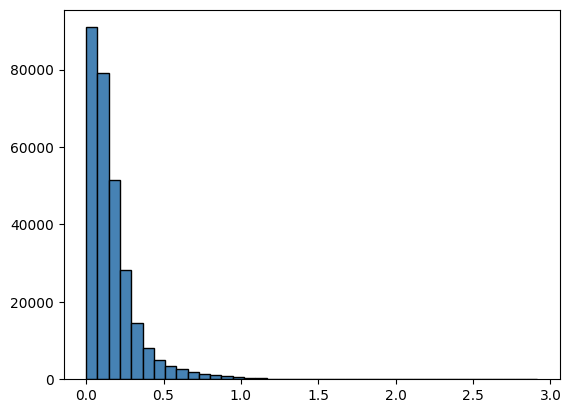

In [33]:
plt.hist(x = a, # 指定绘图数据
        bins = 40, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
)
# plt.savefig("./final_result/weight_diffe.png")
# plt.close()
plt.show()

In [34]:
weight_df = pd.DataFrame(neighbor_weight_matrix3, index=node_names, columns=node_names)

In [35]:
weight_df

,STIM1,TRPC1,NOS1,ATP2B4,ABCC9,KCNJ11,HADHA,HADHB,GTF2E2,GTF2E1,...,ADIG,NPPC,SIRPB2,ENPP3,TIMD4,GPR153,HDC,CSMD1,BHLHE22,PROKR1
STIM1,0.0,0.161963,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRPC1,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOS1,0.0,0.000000,0.0,0.099973,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATP2B4,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABCC9,0.0,0.000000,0.0,0.000000,0.0,0.60079,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GPR153,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HDC,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CSMD1,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BHLHE22,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


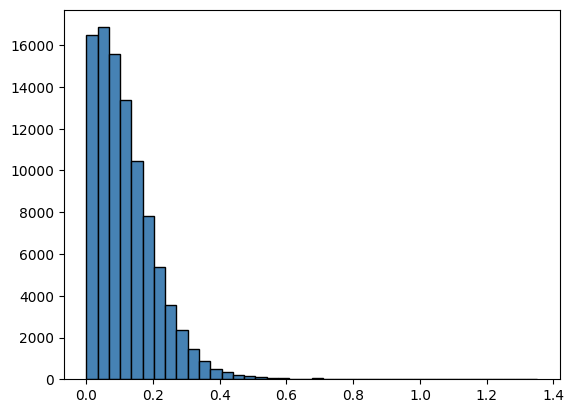

In [36]:
drivers_cand = [i.strip() for i in open("./Out/genes_for_extract_cancer_SCCs.txt",'r').readlines()]
drivers_cand = list(set(drivers_cand).intersection(set(node_names)))
drivers_index = [node_names_to_index[g] for g in drivers_cand]
driver_matrix = neighbor_weight_matrix3[drivers_index][:,drivers_index]

a = driver_matrix.reshape(-1)[driver_matrix.reshape(-1)>0].tolist()
plt.hist(x = a, # 指定绘图数据
        bins = 40, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
)
# plt.savefig("./final_result/weight_diffe.png")
# plt.close()
plt.show()

In [37]:
weight_df_driver = pd.DataFrame(driver_matrix, index=[node_names[i] for i in drivers_index], columns=[node_names[i] for i in drivers_index])
G_driver = nx.from_pandas_adjacency(weight_df_driver,create_using=nx.MultiDiGraph)
G_driver.remove_edges_from(list(nx.selfloop_edges(G_driver)))
weight_df_driver

,PCM1,SORCS1,GNAS,HIST1H2BA,TBC1D15,POLR1A,CBX8,ITGA3,MDK,MKI67,...,ZNRF3,INTU,CDK5R2,MYH8,PDE4D,HADHA,CR2,SERTAD3,TXK,ECHS1
PCM1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SORCS1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GNAS,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HIST1H2BA,0.0,0.0,0.0,0.0,0.0,0.0,0.054644,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TBC1D15,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HADHA,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SERTAD3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TXK,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0.16000000000000003
0.24000000000000002
0.32000000000000006
0.4
0.4800000000000001
[22, 24, 25, 32, 35, 33, 42, 52, 38, 26, 19, 11, 7, 4, 2, 1, 0, 0, 0, 0]


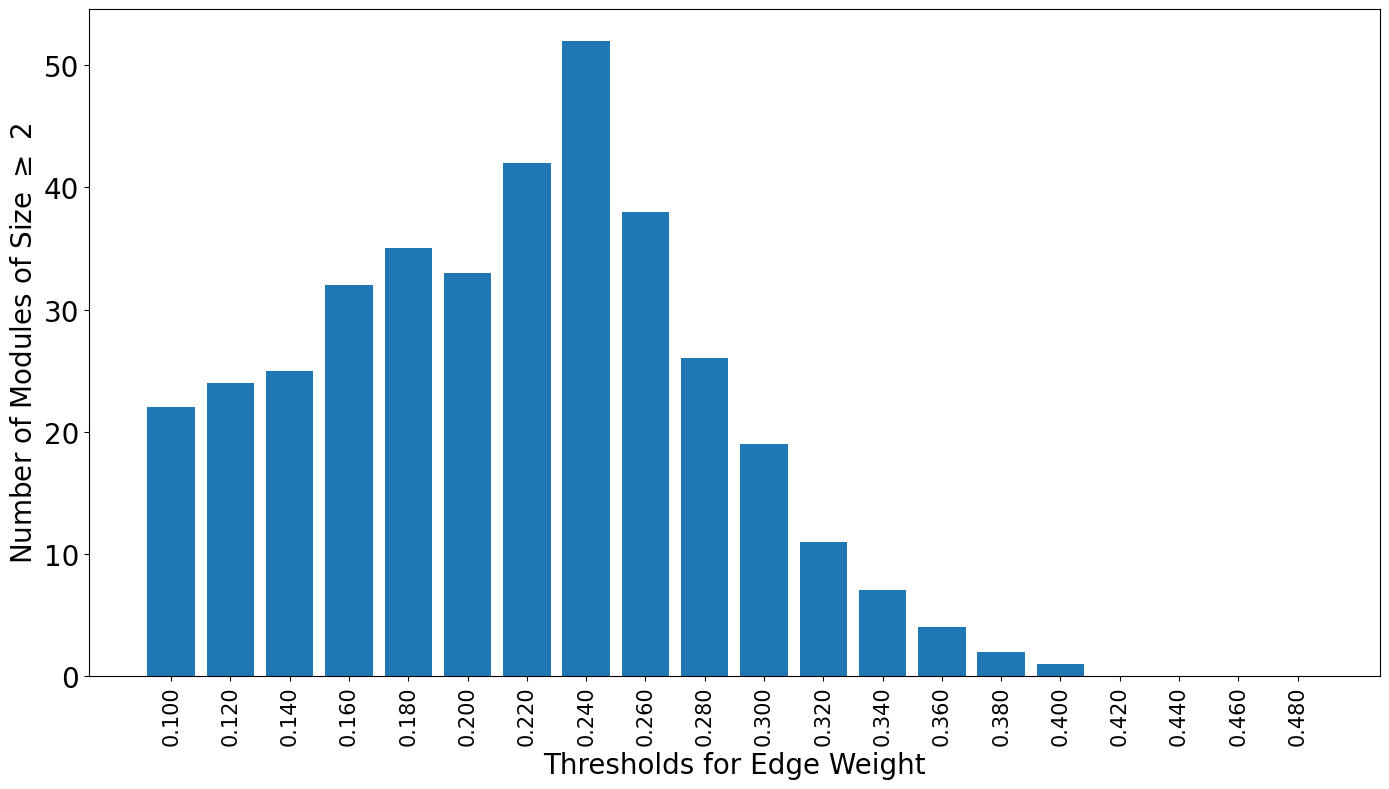

In [38]:
find_optime_threshold(G_driver,'<',np.arange(.1, .5, 0.02),2) # G,operator,candidate_thres,min_gene_num

In [23]:
min_edge_weight = 0.24
all_SCCs = find_SCCs(G_driver,min_edge_weight,'<',2) # G,thres, operator,min_gene_num

In [24]:
print([len(i) for i in all_SCCs])
print(all_SCCs[1])

[213, 32, 13, 8, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
['CRNKL1', 'LSM1', 'SART3', 'PSME4', 'SNRPN', 'LSM4', 'LSM3', 'CCNL1', 'SNRPG', 'ZRSR2', 'LIN28B', 'PSMA1', 'THOC5', 'PRCC', 'TOE1', 'SNRPE', 'LSM5', 'KRT13', 'RSRC1', 'PAXBP1', 'SNRPF', 'DIS3L', 'EXOSC6', 'CD2BP2', 'PLRG1', 'UPF2', 'SNRNP40', 'LIN28A', 'SF3A2', 'U2AF1', 'DDX23', 'AQR']


In [102]:

for i in range(len(all_SCCs)):
    with open(f'./module_gene/module_{i}_{len(all_SCCs[i])}genes.txt','w') as f:
        f.write('\n'.join(all_SCCs[i]))


In [104]:
write_SCCs(weight_df_driver,
                       all_SCCs,0.24,drivers_gold,
           './final_result/modules_subMean_DivMean_threshold0.24_driver.txt',
           './final_result/modules_geneAttr_subMean_DivMean_threshold0.24_driver.txt') 

In [25]:
neighbor_weight_matrix3

array([[0.        , 0.16196282, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [237]:
index = torch.tensor(neighbor_weight_matrix3).sort(0,descending=True)[1]
neighbor_weight_rank_matrix = index.sort(0)[1] + 1
neighbor_weight_rank_matrix[neighbor_weight_matrix3==0] = 0
neighbor_weight_rank_matrix = neighbor_weight_rank_matrix.detach()
neighbor_weight_rank_matrix = neighbor_weight_rank_matrix.numpy()
weight_matrix = pd.DataFrame(neighbor_weight_rank_matrix, index=node_names, columns=node_names)
G = nx.from_pandas_adjacency(weight_matrix,create_using=nx.MultiDiGraph)
G.remove_edges_from(list(nx.selfloop_edges(G)))

4
8
12
16
20
24
28
32
36
40
44
48
52
56
[301, 708, 870, 401, 268, 180, 148, 121, 98, 80, 71, 65, 58, 51, 45, 43, 43, 40, 39, 39, 39, 39, 37, 36, 35, 35, 34, 35, 34, 34, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]


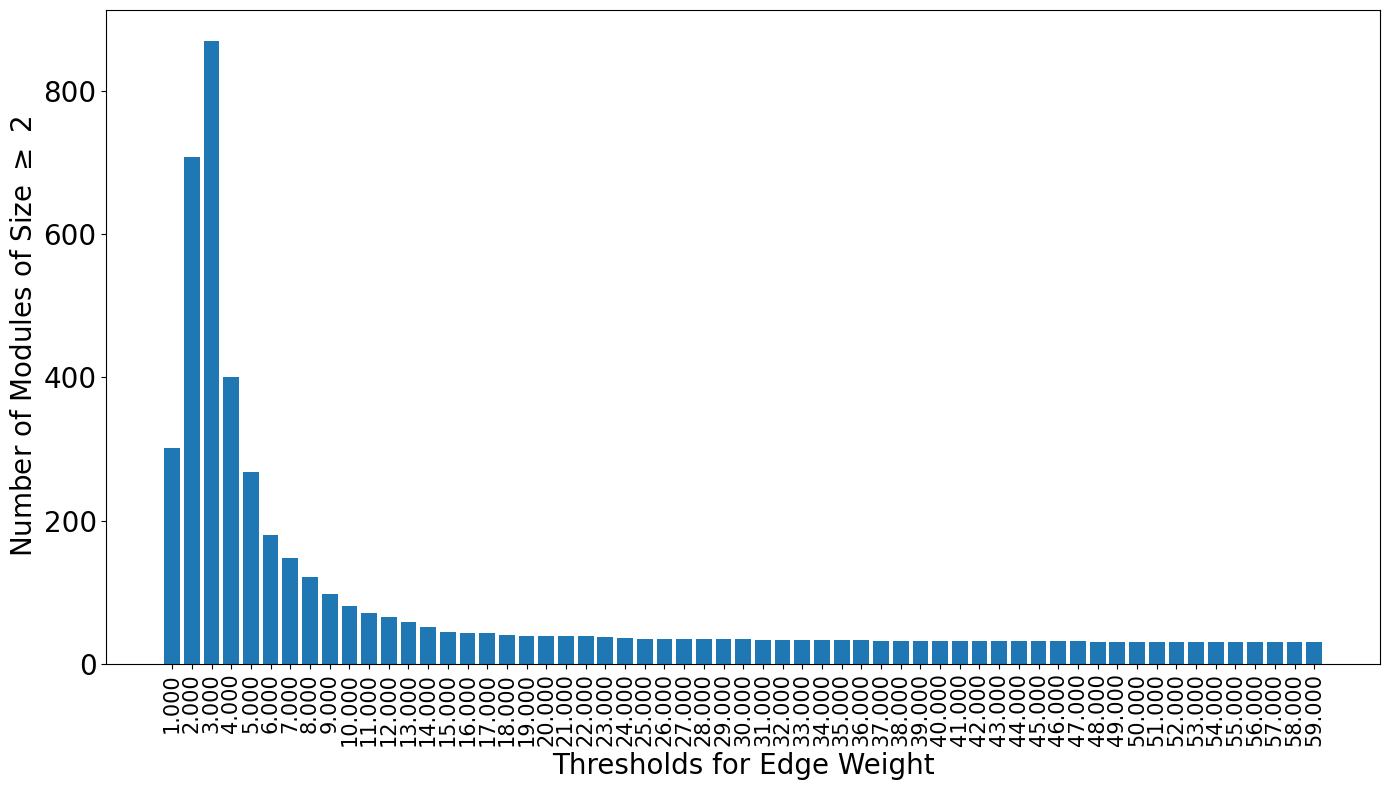

In [235]:
find_optime_threshold(G,'>',list(range(1,60)),2) # G,operator,candidate_thres,min_gene_num

In [279]:
min_edge_weight = 3
all_SCCs = find_SCCs(G,min_edge_weight,'>',2) # G,thres, operator,min_gene_num

In [288]:
analysis(all_SCCs)

151
3.0927152317880795
{'JAK2', 'DTX1', 'PLAUR', 'IGF2', 'DKK3', 'E2F3', 'TIMP1', 'IGFBP1', 'CRP'}
{'FBLN1', 'DEFA1', 'SRA1', 'E2F3'}


In [16]:
# random_weights  = generate_random_weight()
random_weights = np.load('./final_result/weights_random.npy')
print(random_weights)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
index_random = torch.tensor(random_weights).sort(0,descending=True)[1]
random_weight_rank_matrix = index_random.sort(0)[1] + 1
random_weight_rank_matrix[random_weights==0] = 0
random_weight_rank_matrix = random_weight_rank_matrix.detach()
random_weight_rank_matrix = random_weight_rank_matrix.numpy()
random_weight_matrix = pd.DataFrame(random_weight_rank_matrix, index=node_names, columns=node_names)
G_random = nx.from_pandas_adjacency(random_weight_matrix,create_using=nx.MultiDiGraph)
G_random.remove_edges_from(list(nx.selfloop_edges(G_random)))

4
8
12
16
20
24
28
32
36
40
44
48
52
56
[221, 286, 251, 176, 124, 82, 66, 56, 45, 39, 38, 29, 25, 24, 23, 22, 22, 20, 20, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 10]


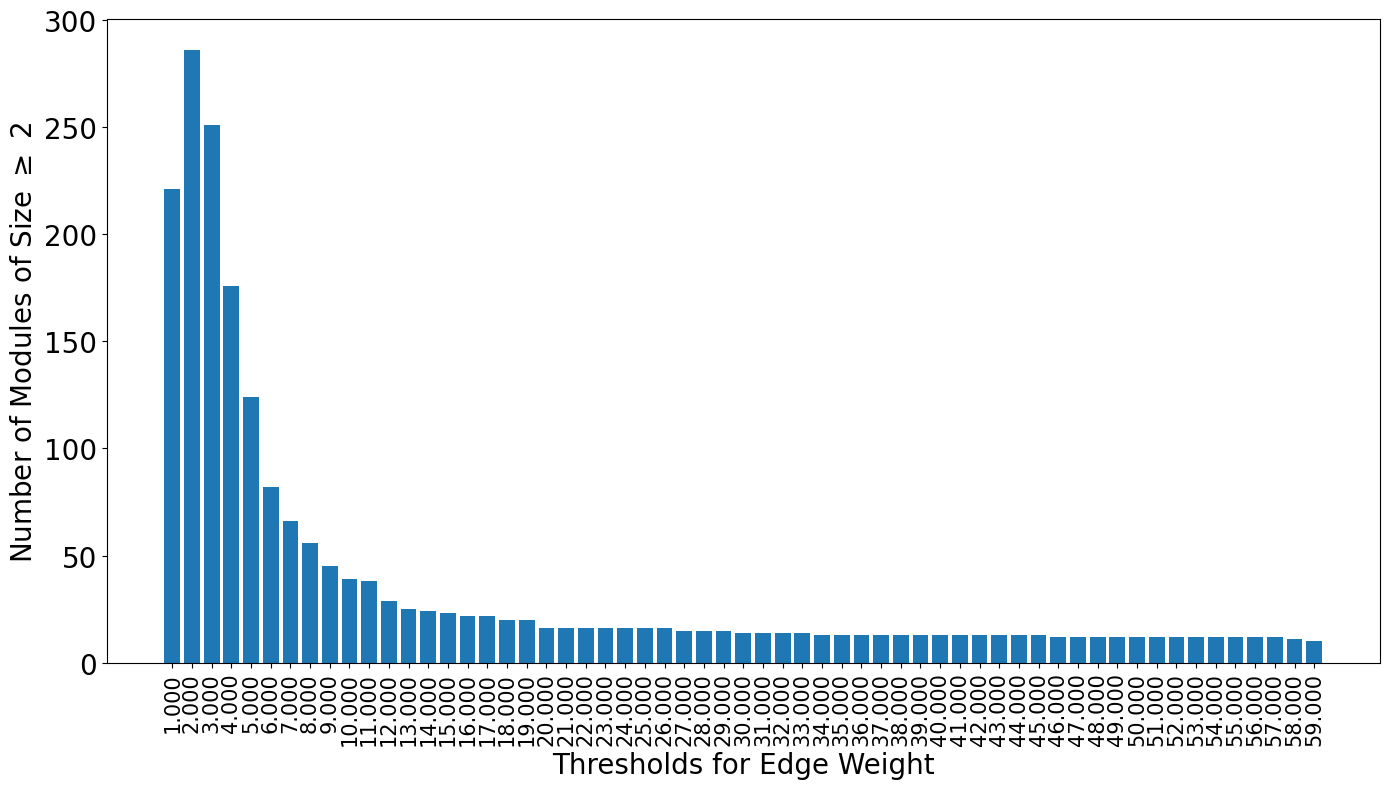

In [18]:
find_optime_threshold(G_random,'>',list(range(1,60)),2) # G,operator,candidate_thres,min_gene_num

In [19]:
min_edge_weight = 2
all_SCCs_random = find_SCCs(G_random,min_edge_weight,'>',2) # G,thres, operator,min_gene_num

In [20]:
analysis(all_SCCs_random)

41
2.1707317073170733
{'GNAS'}
set()


In [37]:
neighbor_weight_matrix3

array([[0.        , 0.01023979, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

0.56
0.6400000000000001
0.7200000000000002
0.8000000000000003
0.8800000000000003
0.9600000000000004
1.0400000000000005
1.1200000000000006
1.2000000000000006
1.2800000000000007
1.3600000000000008
1.4400000000000008
1.520000000000001
1.600000000000001
1.680000000000001
1.7600000000000011
1.8400000000000012
1.9200000000000013
[294, 289, 283, 304, 300, 297, 295, 308, 315, 325, 416, 422, 422, 420, 434, 441, 451, 459, 472, 456, 485, 495, 498, 502, 482, 481, 469, 489, 475, 467, 455, 454, 445, 424, 418, 407, 402, 389, 377, 370, 363, 351, 346, 344, 331, 316, 301, 284, 275, 273, 265, 260, 250, 242, 232, 221, 214, 213, 207, 205, 201, 194, 187, 182, 180, 178, 174, 165, 161, 156, 151, 145, 139, 129, 126]


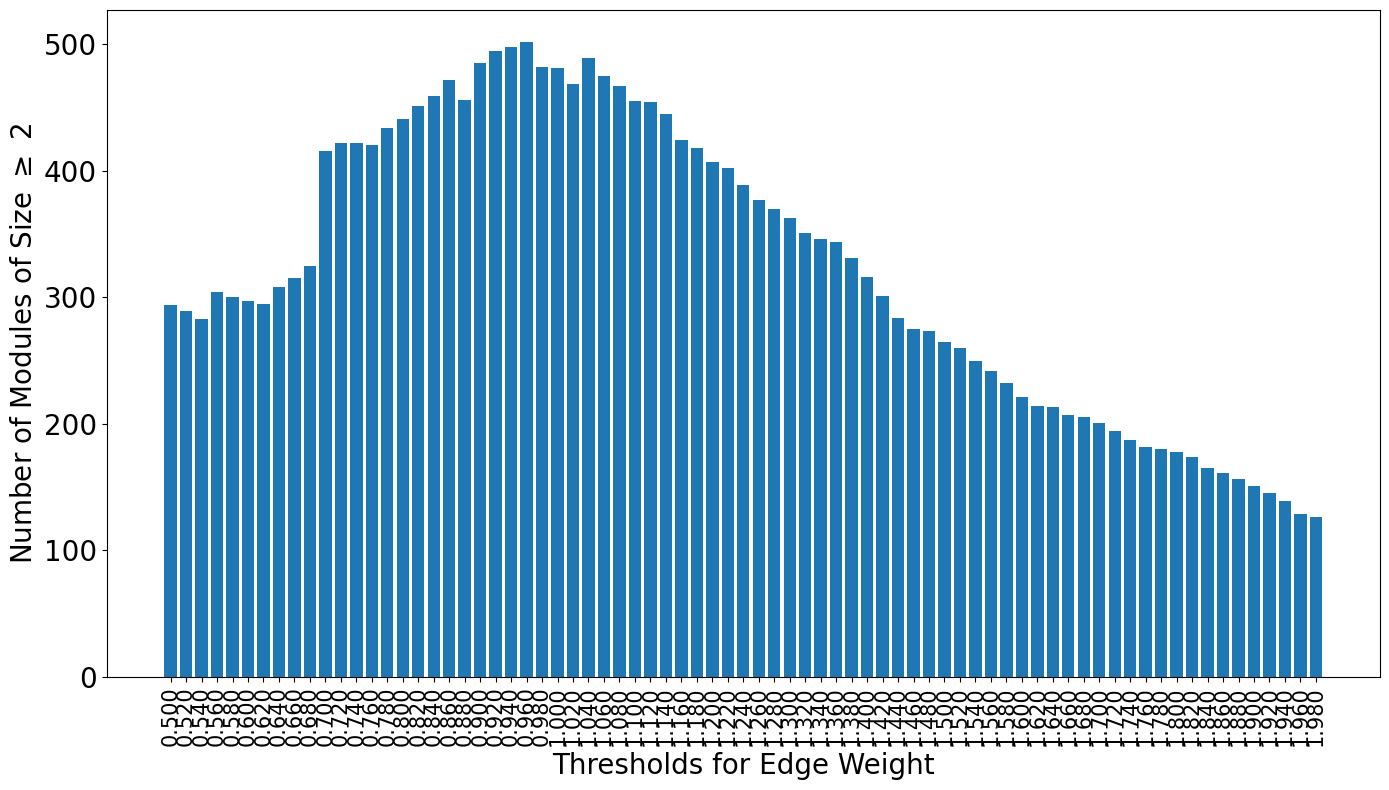

In [68]:
weight_matrix = pd.DataFrame(neighbor_weight_matrix3, index=node_names, columns=node_names)
G = nx.from_pandas_adjacency(weight_matrix,create_using=nx.MultiDiGraph)
G.remove_edges_from(list(nx.selfloop_edges(G)))
find_optime_threshold(G,'<',np.arange(.5, 2, 0.02),2) # G,operator,candidate_thres,min_gene_num

In [69]:
min_edge_weight = 0.960
all_SCCs = find_SCCs(G,0.960,'<',2) # G,thres, operator,min_gene_num
all_SCCs_cancer_related = extract_cancer_related_SCCs(all_SCCs,drivers_gold)


In [70]:
analysis(all_SCCs_cancer_related)

44
2.8863636363636362
{'ESCO2', 'S100A4', 'CBX8'}
set()


In [73]:
print([len(set(i).intersection(drivers_gold)) for i in all_SCCs_cancer_related])

[1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [76]:
print(all_SCCs_cancer_related[1])

['PHF2', 'HIST1H2BE', 'USP37', 'CBX8', 'ESCO2', 'ZNF362', 'HIST1H2BF', 'CIZ1', 'S100A4']


In [77]:
write_SCCs(pd.DataFrame(neighbor_weight_matrix3, 
                        index=node_names, columns=node_names),
                       all_SCCs_cancer_related,0.960,drivers_gold,
           './final_result/modules_subMean_DivMean_threshold0.960.txt',
           './final_result/modules_geneAttr_subMean_DivMean_threshold0.960.txt') #weight_df,all_SCCs,min_edge_weight,drivers_gold,module_outpath,module_gene_outpath

0.16000000000000003
0.24000000000000002
0.32000000000000006
0.4
0.4800000000000001
[11, 13, 14, 14, 17, 21, 22, 22, 22, 21, 20, 20, 18, 19, 24, 25, 24, 26, 30, 26]


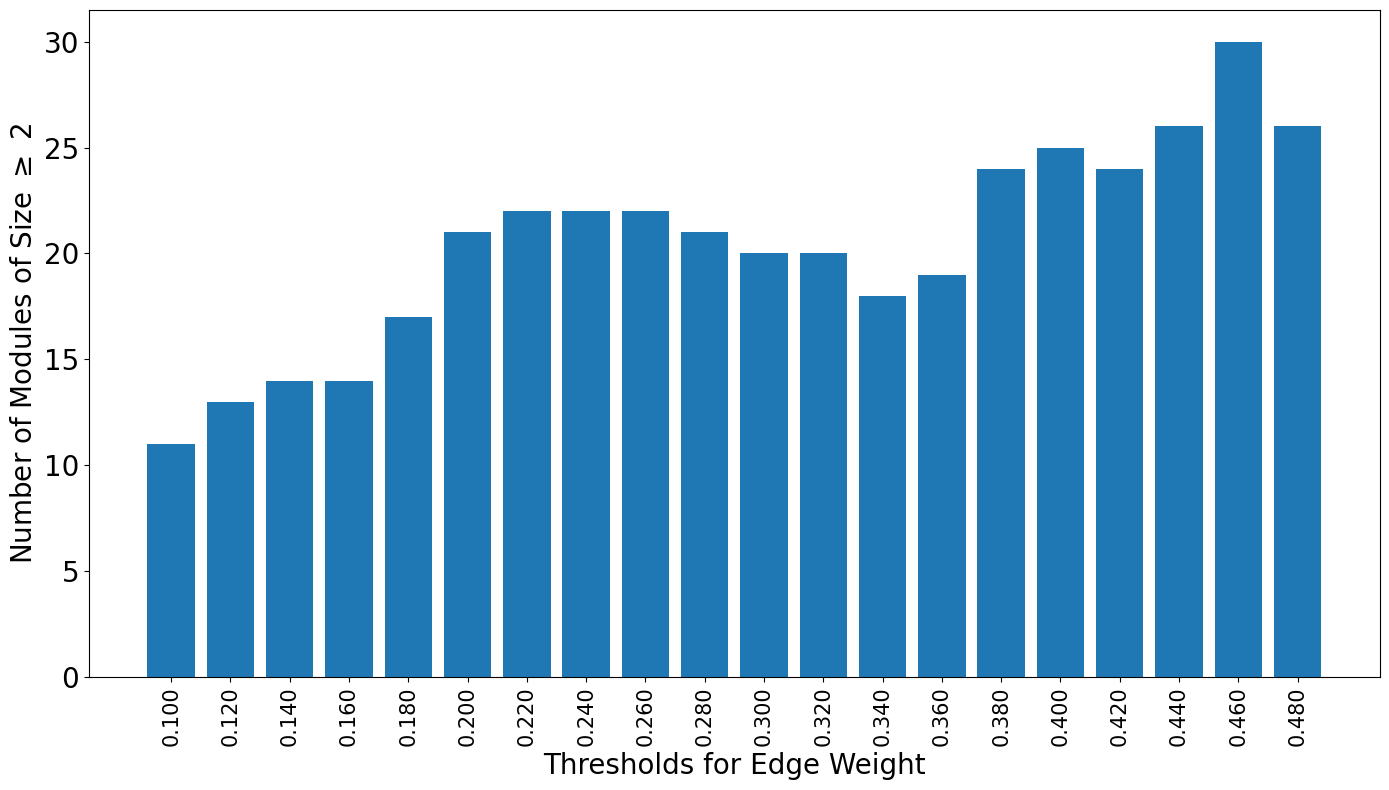

In [54]:
weight_matrix_random = pd.DataFrame(random_weights, index=node_names, columns=node_names)
G_random = nx.from_pandas_adjacency(weight_matrix_random,create_using=nx.MultiDiGraph)
G_random.remove_edges_from(list(nx.selfloop_edges(G_random)))
find_optime_threshold(G_random,'<',np.arange(.1, .5, 0.02),2) # G,operator,candidate_thres,min_gene_num

In [62]:
min_edge_weight = 0.46
all_SCCs_random = find_SCCs(G_random,0.46,'<',2) # G,thres, operator,min_gene_num
all_SCCs_random_cancer_related = extract_cancer_related_SCCs(all_SCCs_random,drivers_gold)

In [63]:
analysis(all_SCCs_random)
print(all_SCCs_random_cancer_related)

6
2.0
{'ROBO1'}
set()
[['ARPP19', 'ROBO1'], ['CNTN2', 'L1CAM'], ['CCL11', 'CCL2'], ['IKZF4', 'IKZF2'], ['SLC34A2', 'SLC30A3'], ['HOXD9', 'MEIS1']]


In [66]:
write_SCCs(weight_matrix_random,all_SCCs_random_cancer_related,0.46,drivers_gold,'./final_result/modules_random.txt','./final_result/modules_geneAttr_random.txt') #weight_df,all_SCCs,min_edge_weight,drivers_gold,module_outpath,module_gene_outpath

In [115]:
def weight_distribution():
    drivers_gold = [i.strip() for i in open("./data/796true.txt",'r').readlines()]
    non_driver_gold = [i.strip() for i in open("./data/2187false.txt",'r').readlines()]
    neighbor_weight_matrix = np.load("./Out/weight.npy")
    mean_weight = []
    for j in range(neighbor_weight_matrix.shape[1]):
        mean_weight.append(neighbor_weight_matrix[:,j][neighbor_weight_matrix[:,j]>0].mean())
    neighbor_weight_matrix2 = torch.zeros((len(node_names),len(node_names)),requires_grad=False).numpy()
    for j in range(len(node_names)):
        neighbor_weight_matrix2[:,j] = (neighbor_weight_matrix[:,j]-mean_weight[j])/mean_weight[j]
    neighbor_weight_matrix2[neighbor_weight_matrix2<=0] = 0
#     print(neighbor_weight_matrix2)
    drivers_gold_index = [node_names_to_index[i] for i in drivers_gold]
    non_drivers_gold_index = [node_names_to_index[i] for i in non_driver_gold]
    drivers_gold_weight = neighbor_weight_matrix2[drivers_gold_index]
    non_drivers_gold_weight = neighbor_weight_matrix2[non_drivers_gold_index]
    drivers_gold_weight = drivers_gold_weight[drivers_gold_weight>0].reshape(-1).tolist()
    non_drivers_gold_weight = non_drivers_gold_weight[non_drivers_gold_weight>0].reshape(-1).tolist()
    plt.hist(x = drivers_gold_weight, # 指定绘图数据
        bins = 50, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
    )
    plt.show()
    plt.close()
    plt.hist(x = non_drivers_gold_weight, # 指定绘图数据
        bins = 50, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
    )
    plt.show()
    print(np.mean(drivers_gold_weight))
    print(np.mean(non_drivers_gold_weight))

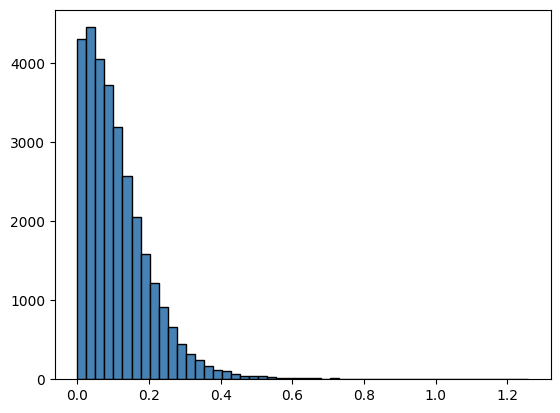

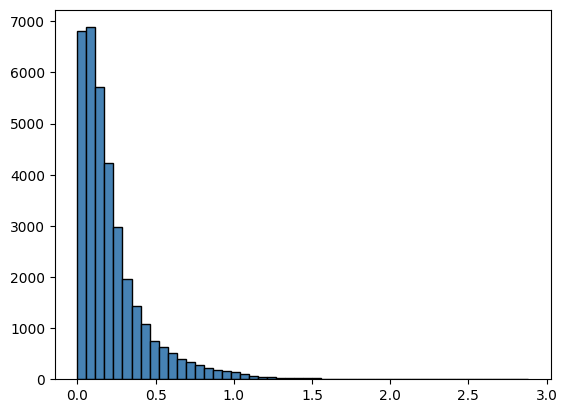

0.11473012823793767
0.2223228977819852


In [116]:
weight_distribution()

In [14]:
module_dir = "./module_gene/"
genes = []
for file in os.listdir(module_dir):
    genes += [line.strip() for line in open(f"{module_dir}/{file}",'r').readlines()]
# print(genes)

['TRA2A', 'NXF1', 'FHOD3', 'HERC2', 'ALDOA', 'RAD52', 'WRN', 'MON2', 'PTPRN2', 'FHOD1', 'NCOA6', 'HNF1A', 'GATA5', 'LIMK1', 'ROCK1', 'GINS3', 'GINS4', 'CEP162', 'OFD1', 'PSMC6', 'BASP1', 'INTU', 'SBDS', 'RASSF2', 'KPNA3', 'KSR2', 'CDC37', 'FLNB', 'NUP210', 'RBPJ', 'NOTCH4', 'TANK', 'KPNA2', 'ZBTB17', 'KLF5', 'PDE3A', 'CSDE1', 'MPHOSPH6', 'EXOSC3', 'FOLH1', 'FABP7', 'PPIL3', 'GOT1', 'MTAP', 'GLO1', 'GMPS', 'MAP2K3', 'YWHAG', 'TUBB', 'MAP2K5', 'MAPK7', 'MAP2K6', 'MAP3K2', 'MAPK8IP1', 'MITF', 'TFEB', 'TNFRSF11A', 'VAV3', 'TCF7', 'RUNX3', 'H3F3A', 'TH', 'SNAI1', 'TRIM5', 'PKM', 'HLA-DRB5', 'EHHADH', 'POC1A', 'CEP63', 'PRDM9', 'CCDC14', 'PEX5', 'TRIM54', 'CEP192', 'CEP152', 'PCM1', 'SCP2', 'HMGCL', 'POC5', 'SIM2', 'MATR3', 'POLD1', 'HSPH1', 'KRT13', 'PAXBP1', 'PRCC', 'PSMA1', 'DDX23', 'LSM3', 'AQR', 'RSRC1', 'SNRPN', 'EXOSC6', 'LSM1', 'U2AF1', 'CCNL1', 'THOC5', 'SNRPG', 'LIN28B', 'LSM5', 'CRNKL1', 'CD2BP2', 'LSM4', 'SART3', 'LIN28A', 'DIS3L', 'TOE1', 'SNRPF', 'SF3A2', 'PLRG1', 'PSME4', 'SNR